# Random forest and gradient boosting trees

Put simple, a **random forest** is an ensemble of decision trees in which each decision tree is trained with a specific random noise. The logic behind this model is that multiple uncorrelated indivdual decision trees mixed randomly are expected to perform better as a group than they do alone.

The main idea behind **gradient boosting** is building models sequentially, where each subsequent model try to reduce the error from the previous one based on a *loss function*. Therefore, the goal is to minimize the loss function by addition of weak learners using gradient descent.

## Overview

In this notebook we will continue elaborating on decision trees. Here we will illustrate the use of Random Forest and Gradient Boosting for classification and regression models

# Libraries

In [1]:
import numpy      as np
import pandas     as pd

# pip installation of mendeleev is not up to date, so we need to install it from the git repository
# ! pip install git+https://github.com/lmmentel/mendeleev.git
import mendeleev  as mendel

import matplotlib.pyplot as plt

from sklearn                 import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import train_test_split

from pymatgen.core.periodic_table import Element

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

blue   = '#0021A5'
orange = '#FA4616'

## 1. Data for classification

We will select 47 elements that occur in the fcc, hcp, and bcc structure. The elements listed were chosen because querying them for these properties yields a dataset with no unknown values, and because they represent the three most common crystallographic structures. We then query both Pymatgen and Mendeleev to get a complete set of properties per element. We will use this data to create the features from which the model will train and test.

In [2]:
# Define the attributes that we will query from the Mendeleev and Pymatgen databases

fcc = ['Ag', 'Al', 'Au', 'Cu', 'Ir',
       'Ni', 'Pb', 'Pd', 'Pt', 'Rh',
       'Th', 'Yb']

bcc = ['Ba', 'Ca', 'Cr', 'Cs', 'Eu',
       'Fe', 'Li', 'Mn', 'Mo', 'Na',
       'Nb', 'Rb', 'Ta', 'V',  'W']

hcp = ['Be', 'Cd', 'Co', 'Dy', 'Er',
       'Gd', 'Hf', 'Ho', 'Lu', 'Mg',
       'Re', 'Ru', 'Sc', 'Tb', 'Ti',
       'Tl', 'Tm', 'Y',  'Zn', 'Zr']

query_mendeleev = ['atomic_number', 'atomic_volume',
                   'boiling_point', 'en_ghosh', 
                   'evaporation_heat', 'heat_of_formation',
                   'melting_point', 'specific_heat']

query_pymatgen  = ['atomic_mass', 'atomic_radius',
                   'electrical_resistivity', 'molar_volume',
                   'bulk_modulus', 'youngs_modulus',
                   'average_ionic_radius', 'density_of_solid',
                   'coefficient_of_linear_thermal_expansion']

elements = fcc + bcc + hcp

queries  = query_mendeleev + query_pymatgen

# randomly shuflle the elements
np.random.seed(42)
np.random.shuffle(elements)

all_attributes, all_labels = [], []

# Iterate over elements
for item in elements:
    attributes = []
    
    element = mendel.element(item)

    # Query Mendeleev
    for i in query_mendeleev:    
        attributes.append( getattr(element,i) )

    element = Element(item)

    # Query Pymatgen
    for i in query_pymatgen:
        attributes.append( getattr(element,i) )
    
    # Append queries to the list
    all_attributes.append(attributes)
    
    if (item in fcc):
        all_labels.append(0)

    elif (item in bcc):
        all_labels.append(1)

    elif (item in hcp):
        all_labels.append(2)

# Create a dataframe with the values
dataframe = pd.DataFrame(all_attributes, columns=queries)

/var/folders/4n/n4j1d7sd4bq5_h54mhjlkfy80000gp/T/ipykernel_53914/1553972551.py:51: UserWarning: No data available for coefficient_of_linear_thermal_expansion for Cs
  attributes.append( getattr(element,i) )
/var/folders/4n/n4j1d7sd4bq5_h54mhjlkfy80000gp/T/ipykernel_53914/1553972551.py:51: UserWarning: No data available for coefficient_of_linear_thermal_expansion for Rb
  attributes.append( getattr(element,i) )
/var/folders/4n/n4j1d7sd4bq5_h54mhjlkfy80000gp/T/ipykernel_53914/1553972551.py:51: UserWarning: No data available for bulk_modulus for Zr
  attributes.append( getattr(element,i) )


Some of the values are not available for a reduced number of elements, so we will fill manually that information to our dataframe.

In [3]:
# Missing value for Cesium
# Ref: David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition. CRC Press. Boca Raton, Florida, 2003

idx = dataframe.index[dataframe['atomic_number'] == 55]
jdx = dataframe.columns.get_loc("coefficient_of_linear_thermal_expansion")

dataframe.iloc[idx, jdx] = 0.000097 

# Missing value for Rubidium
# Ref: https://www.azom.com/article.aspx?ArticleID=1834

idx = dataframe.index[dataframe['atomic_number'] == 37]
jdx = dataframe.columns.get_loc("coefficient_of_linear_thermal_expansion")

dataframe.iloc[idx, jdx] = 0.000090 

# Missing value for Ruthenium
# Ref: https://www.webelements.com/ruthenium/thermochemistry.html

idx = dataframe.index[dataframe['atomic_number'] == 44]
jdx = dataframe.columns.get_loc("evaporation_heat")

dataframe.iloc[idx, jdx] = 595 # kJ/mol 


# Missing value for Zirconium
# Ref: https://materialsproject.org/materials/mp-131

idx = dataframe.index[dataframe['atomic_number'] == 40]
jdx = dataframe.columns.get_loc("bulk_modulus")

dataframe.iloc[idx, jdx] = 94 # GPa 

### 1.1 Preprocessing the data

#### Training/testing split

- We randomly split it into training and testing sets.
- We have 47 elements for which the crystal structure is known and we will use 40 of these as a training set and the remaining 7 as testing set.


#### Feature scaling
- Some machine learning models benefit from feature scaling, which subtracts the mean of the feature and divide by its standard deviation.
$$
\overline{X} = \frac{X - µ}{σ}
$$

- Decision tree based methods such as random forest or gradient boosted trees do not benefit from feature scaling.

- Explanation:
  - Both Random Forests and Gradient Boosted Trees are based on decision trees, which split features using threshold comparisons (e.g., "is feature $ x_j < t $?").
  - These splits are **independent of the feature’s scale**, meaning the model behavior is **invariant to scaling or units**.
  - Unlike distance-based methods (e.g., k-NN, SVMs) or gradient-based optimization in neural networks, tree-based methods do **not rely on feature magnitudes** or distributions.

- Practical Implications:
  - You can use raw, unscaled numerical data directly with tree-based models such as:
    - `RandomForestClassifier`, `RandomForestRegressor` (scikit-learn)
    - `XGBoost`, `LightGBM`, `CatBoost`
  - **Feature scaling is unnecessary** and does not improve performance in these models.
  - However, if you're combining tree-based models with methods that *do* require scaling, or using linear base learners in boosting, scaling might be appropriate.

In [4]:
all_attributes = [ list(dataframe.iloc[x]) for x in range( len(all_attributes) ) ]

all_attributes = np.array(all_attributes, dtype = float)
all_labels     = np.array(all_labels,     dtype = int)

# Split data into 87% training and 13% testing

X_train, X_test, y_train, y_test = train_test_split(all_attributes, all_labels, test_size=0.13, random_state=42)

## 2. Random Forest Classification

The fundamental idea behind a random forest is to combine many decision trees into a single model. Each decision tree in the forest considers a random subset of features and only has access to a random set of the training data points. This increases diversity in the forest leading to more robust overall predictions. When doing a classification, where the targets are a discrete class label, the random forest algorithm takes the majority vote for the predicted class.

In [5]:
# Create the classifier object
random_forest_classification = RandomForestClassifier()

Now that we created the object we have to optimize the hyperparameters for the model. Let's create a list with the available choices.

In [6]:
# List the hyperparameters that can be tuned
for idx, key in enumerate( random_forest_classification.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): bootstrap
( 2): ccp_alpha
( 3): class_weight
( 4): criterion
( 5): max_depth
( 6): max_features
( 7): max_leaf_nodes
( 8): max_samples
( 9): min_impurity_decrease
(10): min_samples_leaf
(11): min_samples_split
(12): min_weight_fraction_leaf
(13): monotonic_cst
(14): n_estimators
(15): n_jobs
(16): oob_score
(17): random_state
(18): verbose
(19): warm_start


### Key Tree Parameters in Random Forest Regression

In Random Forests, individual decision trees are grown using a set of control parameters that govern their depth and complexity. Below are three important hyperparameters:

---

#### **1. `max_depth`**

Defines the **maximum depth** of each tree in the forest.

- It limits the number of splits from root to leaf.
- Controls model complexity and overfitting.
- A tree of depth $ d $ can have up to $ 2^d $ leaf nodes.

> **Effect**:  
> Smaller `max_depth` → simpler trees (less variance, more bias)  
> Larger `max_depth` → deeper trees (more variance, risk of overfitting)

---

#### **2. `min_samples_split`**

Specifies the **minimum number of samples required to split** an internal node.

- A node will only be split if it contains at least `min_samples_split` training examples.
- Helps prevent the creation of small, noisy branches.

> **Default**: 2  
> **Typical range**: Integer $ \geq 2 $ or float in $ (0.0, 1.0] $ representing a fraction of total samples

> **Effect**:  
> Larger values → fewer splits, more regularization  
> Smaller values → more splits, higher model flexibility

---

#### **3. `min_samples_leaf`**

Defines the **minimum number of samples required to be at a leaf node**.

- Ensures that leaves have at least this many training samples.
- Prevents overly specific leaves with few observations.

> **Default**: 1  
> **Typical values**: Integer $\geq 1$ or float in $ (0.0, 0.5] $

> **Effect**:  
> Larger values → smoother predictions, better generalization  
> Smaller values → more granular splits, risk of overfitting

---

These parameters act as **regularization controls** in Random Forests. Tuning them appropriately helps balance the bias-variance tradeoff and improve generalization to unseen data.

>### Assignment
>
> Optimize `min_samples_split`, `max_depth`, and `min_samples_leaf`. Then set the classification object with those parameters

In [7]:
# Optimize `min_samples_split`, `max_depth`, and `min_samples_leaf`.

parameters = {'min_samples_split': [2, 3, 4, 5],
              'max_depth': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4]}

grid_search = GridSearchCV(random_forest_classification, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

random_forest_classification = RandomForestClassifier(**grid_search.best_params_)

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3}


Once we determined the optimal hyperparameters, we can train the model and evaluate its performance. The following code trains the model and evaluates its performance using the testing data.

Training accuracy = 0.850
Testing accuracy  = 0.286


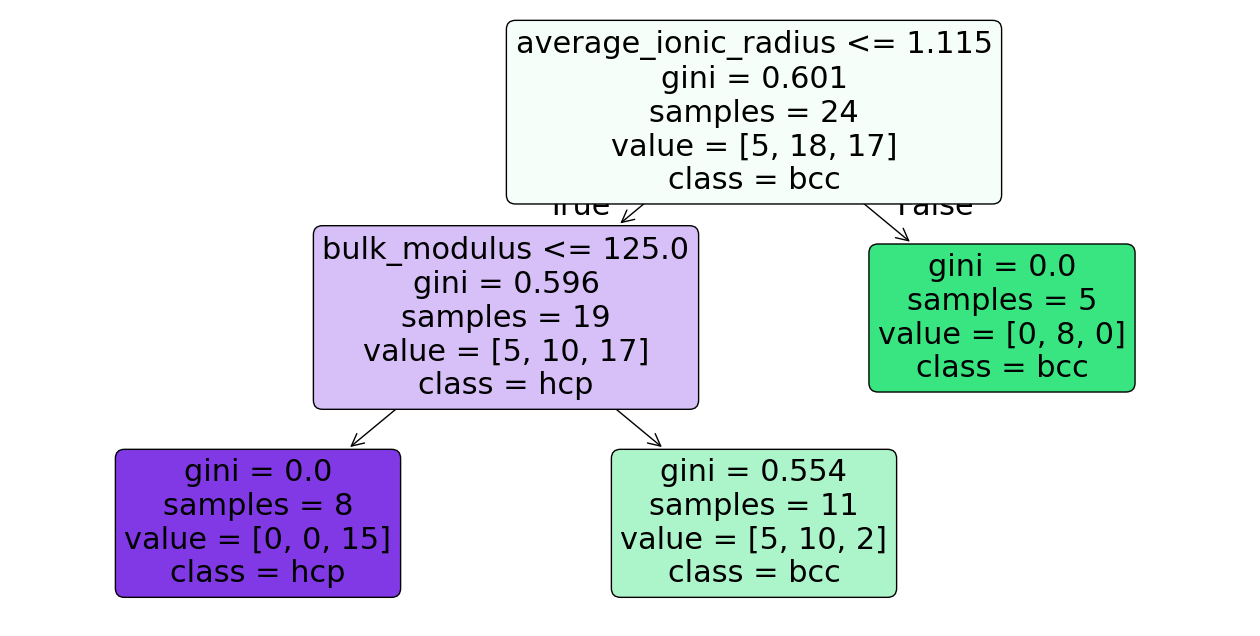

In [8]:
# Train the model
random_forest_classification.fit(X_train, y_train)

# Predict the response for training and testing dataset
predicted_train = random_forest_classification.predict(X_train)
predicted_test  = random_forest_classification.predict(X_test)

# Model Accuracy for training and testing set, how often is the classifier correct?
print(f'Training accuracy = '
      f'{accuracy_score(y_train, predicted_train):.3f}')

print(f'Testing accuracy  = '
      f'{accuracy_score(y_test, predicted_test):.3f}')

# Plot the tree
label_names = ('fcc', 'bcc', 'hcp')

fig = plt.figure(figsize=(16,8))

# Select an individual decision tree, here 0.
_ = tree.plot_tree(random_forest_classification.estimators_[0], feature_names=queries,
                   class_names = label_names, filled=True, impurity=True, rounded=True)

For ease of comparison, we can create a dataframe and collect the labels predicted by our model and the actual labels. We can then compare the two and see how well our model is doing.

In [9]:
reference = np.hstack((y_train, y_test), dtype=str)
predicted = np.hstack((predicted_train, predicted_test), dtype=str)

for i, j in zip( ['0', '1', '2'], ['fcc', 'bcc', 'hcp'] ):
    reference[reference==i] = j
    predicted[predicted==i] = j

data_dictionary = {'AtomicNumber': dataframe['atomic_number'].values,
                   'Reference': reference,
                   'Predicted': predicted,
                   'Status': np.where(reference == predicted, 'Correct', 'Incorrect')}

reference_vs_predicted = pd.DataFrame(data_dictionary)

reference_vs_predicted

,AtomicNumber,Reference,Predicted,Status
0,4,fcc,fcc,Correct
1,21,bcc,bcc,Correct
2,74,hcp,hcp,Correct
3,69,fcc,fcc,Correct
4,73,hcp,hcp,Correct
5,12,bcc,bcc,Correct
6,56,hcp,hcp,Correct
7,25,fcc,fcc,Correct
8,77,hcp,hcp,Correct
9,23,hcp,hcp,Correct


## 3. Gradient Boosting Classification

We can alternatively use gradient boosting an compare with the preocious method. We will use the same training and testing

In [10]:
# Create the classifier object
gradient_boosting_classification = GradientBoostingClassifier()

Before optimizing the hyperparameters, let's list the hyperparameters that can be tuned

In [11]:
for idx, key in enumerate( gradient_boosting_classification.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): ccp_alpha
( 2): criterion
( 3): init
( 4): learning_rate
( 5): loss
( 6): max_depth
( 7): max_features
( 8): max_leaf_nodes
( 9): min_impurity_decrease
(10): min_samples_leaf
(11): min_samples_split
(12): min_weight_fraction_leaf
(13): n_estimators
(14): n_iter_no_change
(15): random_state
(16): subsample
(17): tol
(18): validation_fraction
(19): verbose
(20): warm_start


>### Assignment
>
> Optimize `min_samples_split`, `max_depth`, `min_samples_leaf`, and `learning_rate`. Then set the classification object with those parameters

In [12]:
# Optimize `min_samples_split`, `max_depth`, `min_samples_leaf`, and `learning_rate`.

parameters = {'min_samples_split': [2, 3, 4, 5],
              'max_depth': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4],
              'learning_rate': [0.1, 0.01, 0.001]}

grid_search = GridSearchCV(gradient_boosting_classification, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

gradient_boosting_classification = GradientBoostingClassifier(**grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}


Now that we optimized the hyperparameters, we can train the model.

In [13]:
# Train Decision Tree Classifer
gradient_boosting_classification.fit(X_train, y_train)

# Predict the response for training and testing dataset
predicted_train = gradient_boosting_classification.predict(X_train)
predicted_test  = gradient_boosting_classification.predict(X_test)

# Model Accuracy for training and testing set, how often is the classifier correct?
print(f'Training accuracy = '
      f'{accuracy_score(y_train, predicted_train):.3f}')

print(f'Testing accuracy  = '
      f'{accuracy_score(y_test, predicted_test):.3f}')

Training accuracy = 1.000
Testing accuracy  = 0.429


## 4. Data for regression

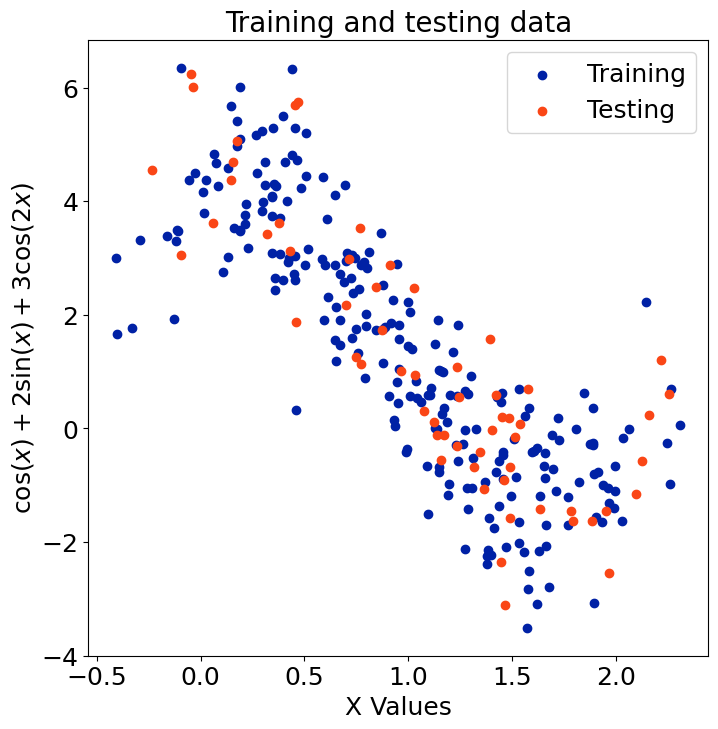

In [14]:
# Create the reference function that generates our data
def reference_function(x):
    return np.cos(x) + 2.0*np.sin(x) + 3.0*np.cos(2.0*x)

np.random.seed(seed=5)

# Generate a data set for machine learning
x = np.linspace(0, 2, 300)
x = x + np.random.normal(0.0, 0.3, x.shape)

y = reference_function(x) + np.random.normal(0.0,1.0, x.shape)

# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (-1,1) )

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=21)

# Plot the training and testing dataset
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(X_train, y_train, c=blue, label='Training')
ax.scatter(X_test, y_test,   c=orange, label='Testing')

ax.set_title('Training and testing data',fontsize=20)

ax.set_xlabel('X Values',fontsize=18)
ax.set_ylabel(r'$ \cos(x)+2\sin(x)+3\cos(2x)$',fontsize=18)

plt.legend(loc='best', fontsize=18)

plt.show()

## 5. Random Forest Regression

Contrary to the classification task, the prediction of a continuous variable is computed for the average of all the individual decision tree estimates.

In [15]:
# Create the object
random_forest_regression = RandomForestRegressor()

Before continuing, we will optimize the hyperparameters of the random forest regression model using a grid search. Let's list our choices

In [16]:
# List the hyperparameters that can be tuned
for idx, key in enumerate( random_forest_regression.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): bootstrap
( 2): ccp_alpha
( 3): criterion
( 4): max_depth
( 5): max_features
( 6): max_leaf_nodes
( 7): max_samples
( 8): min_impurity_decrease
( 9): min_samples_leaf
(10): min_samples_split
(11): min_weight_fraction_leaf
(12): monotonic_cst
(13): n_estimators
(14): n_jobs
(15): oob_score
(16): random_state
(17): verbose
(18): warm_start


>### Assignment
>
> Optimize `min_impurity_decrease`, `min_samples_split`, `max_depth`, `min_samples_leaf`, and `max_leaf_nodes`. Then set the regression object with those parameters

In [17]:
# Optimize `min_impurity_decrease`, `min_samples_split`, `max_depth`,
# `min_samples_leaf`, and `max_leaf_nodes`.

parameters = {'min_impurity_decrease': [0.0, 0.1, 0.2],
              'min_samples_split': [2, 3, 4],
              'max_depth': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3],
              'max_leaf_nodes': [2, 3, 4]}

grid_search = GridSearchCV(random_forest_regression, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

random_forest_regression = RandomForestRegressor(**grid_search.best_params_)

Best parameters: {'max_depth': 2, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 4}


/Users/rhennig/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Now we train our model and evaluate its performance using the RMSE metric.

In [18]:
# Train the optimized regression model
random_forest_regression.fit(X_train, y_train)

# Ccoefficient of determination for the prediction
print(f'Training score = '
      f'{random_forest_regression.score(X_train,y_train):.3f}')

print(f'Testing  score = '
      f'{random_forest_regression.score(X_test,y_test):.3f}\n')

predicted_train = random_forest_regression.predict(X_train)
predicted_test = random_forest_regression.predict(X_test)

training_rmse = np.sqrt( mean_squared_error(y_train, predicted_train) )
testing_rmse = np.sqrt( mean_squared_error(y_test, predicted_test) )
    
print(f'Training RMSE = {training_rmse:.3f}')
print(f'Testing  RMSE = {testing_rmse:.3f}')

Training score = 0.800
Testing  score = 0.764

Training RMSE = 1.004
Testing  RMSE = 1.114


Let's visualize our model

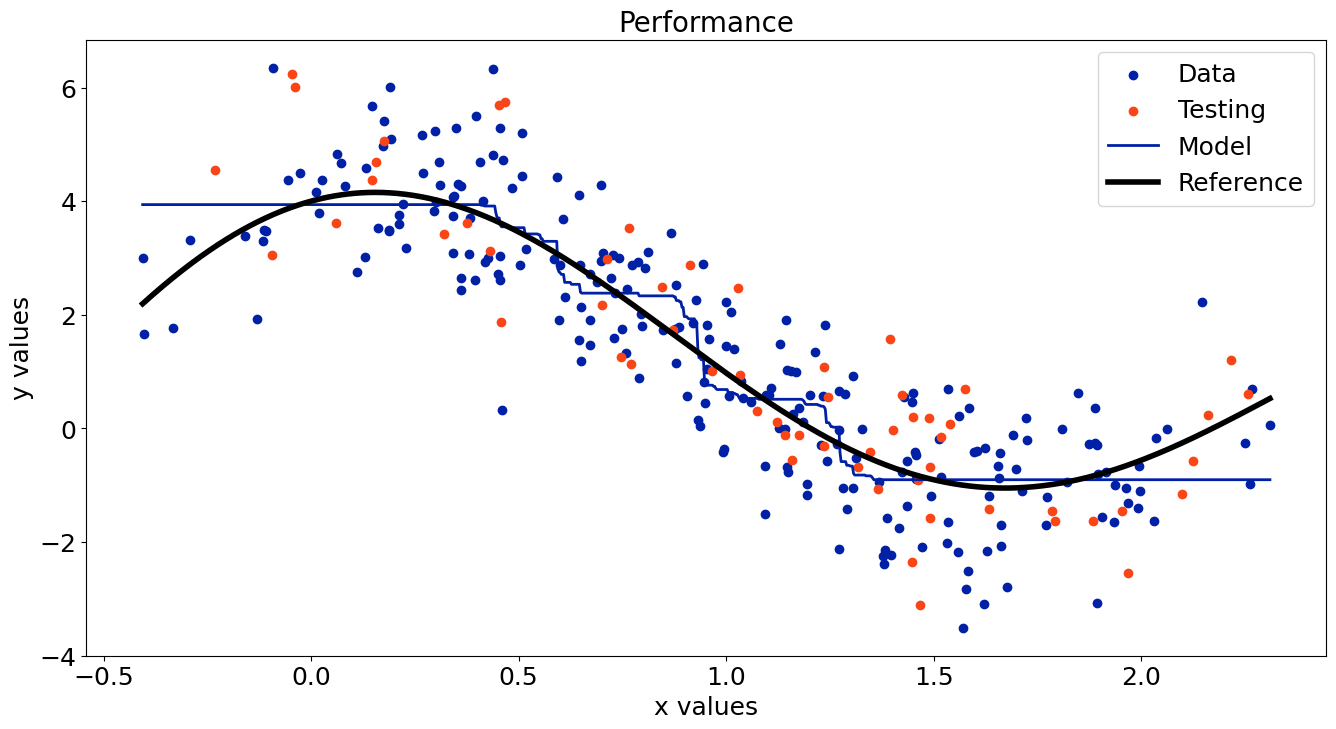

In [19]:
# create a series of sampling points to plot the model
points  = 1000

X_model = np.linspace(np.min(x), np.max(x), num=points)
X_model = X_model.reshape( (-1,1) )

y_model_predictions = random_forest_regression.predict(X_model)
y_model_reference   = reference_function(X_model)

# Plot the dataset
fig,ax=plt.subplots( figsize=(16,8) )

ax.scatter(X_train, y_train, c=blue, label='Data')
ax.scatter(X_test, y_test, c=orange, label='Testing')

ax.plot(X_model, y_model_predictions, c=blue, lw=2, label='Model')
ax.plot(X_model, y_model_reference,   c='k', lw=4, label='Reference')

ax.set_title('Performance', fontsize=20)

ax.set_xlabel('x values', fontsize=18)
ax.set_ylabel('y values', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

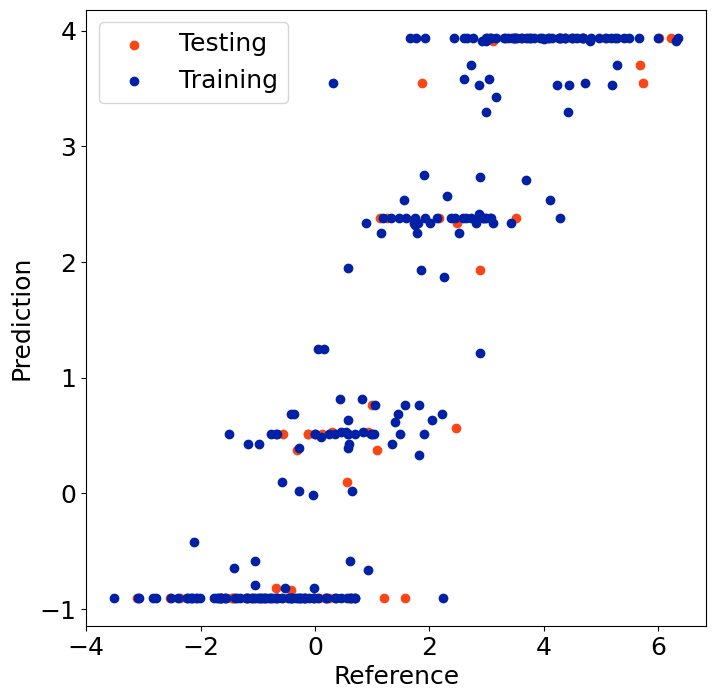

In [20]:
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(y_test, predicted_test, c=orange, label='Testing')
ax.scatter(y_train, predicted_train, c=blue, label='Training')

ax.set_xlabel('Reference', fontsize=18)
ax.set_ylabel('Prediction', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

## 6. Gradient Boosting Regression

In [21]:
# Create the object
gradient_boosting_regression = GradientBoostingRegressor()

Once again, we must optimize the hyperparameters. But first, list our different choices

In [22]:
# List the hyperparameters that can be tuned
for idx, key in enumerate( gradient_boosting_regression.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): alpha
( 2): ccp_alpha
( 3): criterion
( 4): init
( 5): learning_rate
( 6): loss
( 7): max_depth
( 8): max_features
( 9): max_leaf_nodes
(10): min_impurity_decrease
(11): min_samples_leaf
(12): min_samples_split
(13): min_weight_fraction_leaf
(14): n_estimators
(15): n_iter_no_change
(16): random_state
(17): subsample
(18): tol
(19): validation_fraction
(20): verbose
(21): warm_start


>### Assignment
>
> Optimize `learning_rate` and `n_estimators`. Then set the regression object with those parameters

In [23]:
# Optimize `learning_rate` and `n_estimators`.

parameters = {'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators': [100, 200, 300]}

grid_search = GridSearchCV(gradient_boosting_regression, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

gradient_boosting_regression = GradientBoostingRegressor(**grid_search.best_params_)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 300}


Again, we proceed to train our model with the optimized hyperparameters

In [24]:
# Train the optimized regression model
gradient_boosting_regression.fit(X_train, y_train)

# Ccoefficient of determination for the prediction
print(f'Training score = {gradient_boosting_regression.score(X_train,y_train):.3f}')
print(f'Testing  score = {gradient_boosting_regression.score(X_test,y_test):.3f}\n')

predicted_train = gradient_boosting_regression.predict(X_train)
predicted_test = gradient_boosting_regression.predict(X_test)

training_rmse = np.sqrt( mean_squared_error(y_train, predicted_train) )
testing_rmse = np.sqrt( mean_squared_error(y_test, predicted_test) )
    
print(f'Training RMSE = {training_rmse:.3f}')
print(f'Testing  RMSE = {testing_rmse:.3f}')

Training score = 0.855
Testing  score = 0.769

Training RMSE = 0.853
Testing  RMSE = 1.101


Finally, we can plot our model to see the results

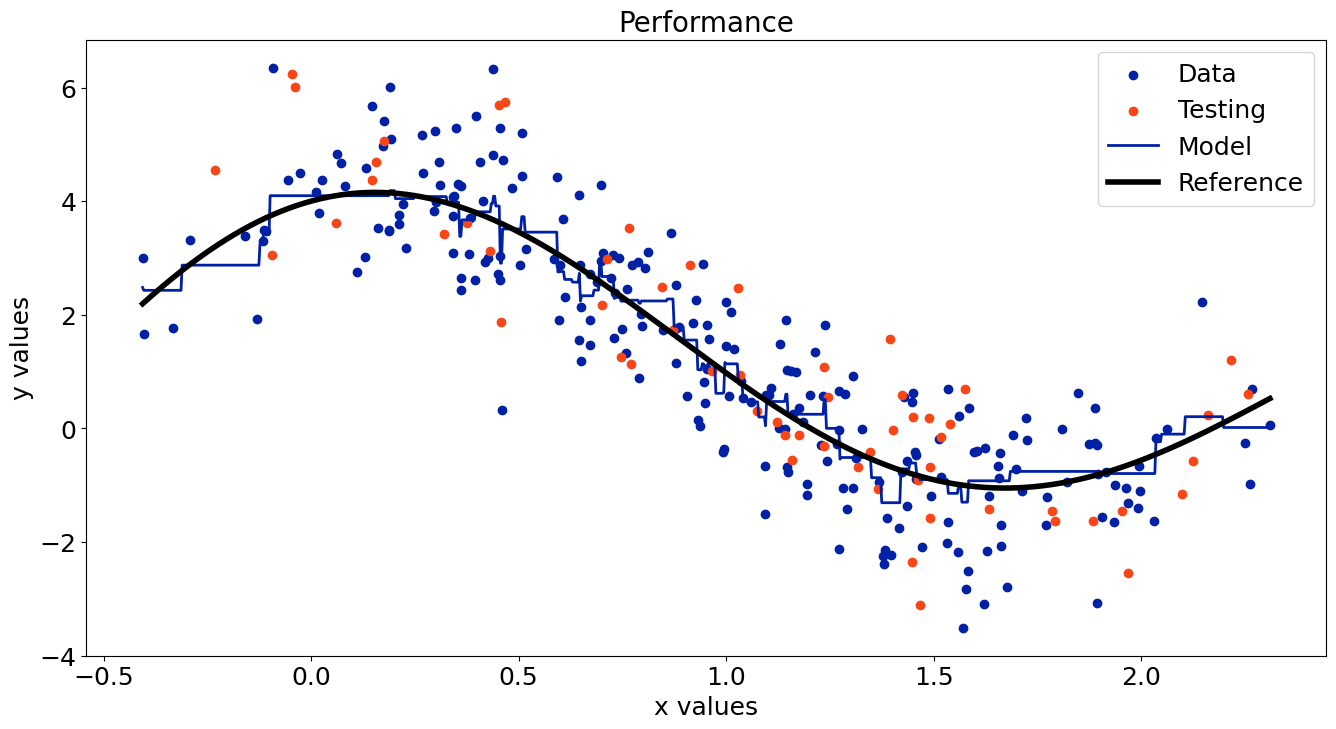

In [25]:
# create a series of sampling points to plot the model
points  = 1000

X_model = np.linspace(np.min(x), np.max(x), num=points)
X_model = X_model.reshape( (-1,1) )

y_model_predictions = gradient_boosting_regression.predict(X_model)
y_model_reference   = reference_function(X_model)

# Plot the dataset
fig,ax=plt.subplots( figsize=(16,8) )

ax.scatter(X_train, y_train, c=blue, label='Data')
ax.scatter(X_test, y_test, c=orange, label='Testing')

ax.plot(X_model, y_model_predictions, c=blue, lw=2, label='Model')
ax.plot(X_model, y_model_reference,   c='k', lw=4, label='Reference')

ax.set_title('Performance', fontsize=20)

ax.set_xlabel('x values', fontsize=18)
ax.set_ylabel('y values', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

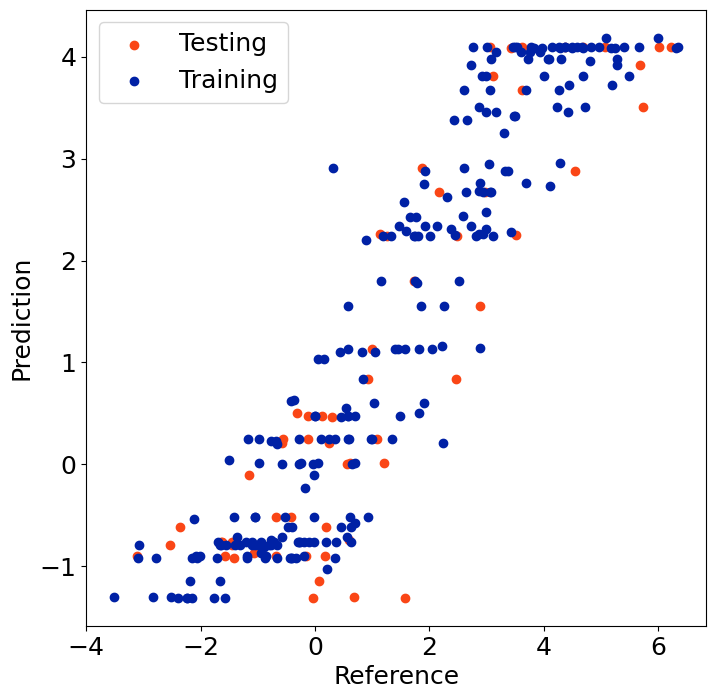

In [26]:
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(y_test, predicted_test, c=orange, label='Testing')
ax.scatter(y_train, predicted_train, c=blue, label='Training')

ax.set_xlabel('Reference', fontsize=18)
ax.set_ylabel('Prediction', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()